## Test on a simple case
Consider the following Poisson Equation
$$
\begin{cases}
    \Delta u = 0\qquad &u\in\Omega\\
    u = xy\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|\ 0< x, y< 1\}$

The exact solution to this problem is $$u = xy.$$

In [1]:
% matplotlib inline
import torch 
import torch.nn.functional as F
#learning rate decay
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [2]:
def draw_graph(mod):
    points = np.arange(0, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [3]:
def cal_loss(mod):
    points = np.arange(0, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            mmm += abs(z[i, j])
            t += 1
    return mmm / t

In [4]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            w[i, j] = U_groundtruth(re)
            t += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [5]:
#U_groundtruth = x * y
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    return (t[0] * t[1]).item()

In [6]:
def validate(mod):
    draw_graph(mod)
    print(cal_loss(mod))

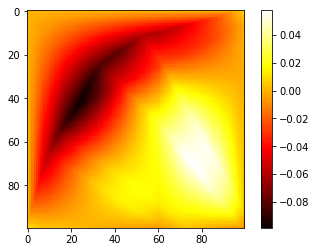

0.02147681844135946


In [9]:
validate(model)

In [8]:
relative_err(model)

0.014388503693285351

In [178]:
#only save the parameters
PATH = 'test_parameters.pkl'
torch.save(model.state_dict(), PATH)

In [38]:
m = 10
PATH = 'test_parameters.pkl'
#从文件读取the_model
model = DeepRitzNet(m)
model.load_state_dict(torch.load(PATH))

In [172]:
model = DeepRitzNet(m)

In [ ]:
#训练the_model
train(model, iterations=50000, milestones=[10000,20000,30000,40000], gamma=1, beta=500, beta_increase=1, 
      alpha=2000, alpha_increase=1.01, initial_lr=0.00001, print_every_iter=5)

4  epoch, loss:  290256.94
4  epoch, regularization loss:  0.005093217
4  loss to real solution:  0.02149834219581824
9  epoch, loss:  221689.7
9  epoch, regularization loss:  0.0054598907
9  loss to real solution:  0.021510767054951873
14  epoch, loss:  297362.4
14  epoch, regularization loss:  0.0072361995
14  loss to real solution:  0.02151773230103421
19  epoch, loss:  362066.25
19  epoch, regularization loss:  0.0059216893
19  loss to real solution:  0.02152196509286391
24  epoch, loss:  301980.9
24  epoch, regularization loss:  0.0052329134
24  loss to real solution:  0.021524660725238887
29  epoch, loss:  331823.7
29  epoch, regularization loss:  0.0038763536
29  loss to real solution:  0.021526331379393894
34  epoch, loss:  303757.3
34  epoch, regularization loss:  0.0067152637
34  loss to real solution:  0.021527395642493372
39  epoch, loss:  293276.8
39  epoch, regularization loss:  0.0036697101
39  loss to real solution:  0.02152805708164025
44  epoch, loss:  447997.44
44  e

339  epoch, loss:  364908.4
339  epoch, regularization loss:  0.0070633003
339  loss to real solution:  0.021529414195659725
344  epoch, loss:  324718.25
344  epoch, regularization loss:  0.005507299
344  loss to real solution:  0.021529427988470084
349  epoch, loss:  274447.44
349  epoch, regularization loss:  0.0069128005
349  loss to real solution:  0.021529379467333635
354  epoch, loss:  259703.66
354  epoch, regularization loss:  0.005943864
354  loss to real solution:  0.021529386733189094
359  epoch, loss:  235767.27
359  epoch, regularization loss:  0.0071208784
359  loss to real solution:  0.02152943944142869
364  epoch, loss:  235189.95
364  epoch, regularization loss:  0.0066031534
364  loss to real solution:  0.02152940766870482
369  epoch, loss:  332756.3
369  epoch, regularization loss:  0.0052515445
369  loss to real solution:  0.021529334887000148
374  epoch, loss:  284039.7
374  epoch, regularization loss:  0.005500078
374  loss to real solution:  0.021529235751175674


669  epoch, loss:  242650.64
669  epoch, regularization loss:  0.008309528
669  loss to real solution:  0.021527533324296803
674  epoch, loss:  352784.7
674  epoch, regularization loss:  0.004317695
674  loss to real solution:  0.021527526181591435
679  epoch, loss:  301847.62
679  epoch, regularization loss:  0.0076702014
679  loss to real solution:  0.02152754108275263
684  epoch, loss:  332934.0
684  epoch, regularization loss:  0.004574466
684  loss to real solution:  0.021527557708015118
689  epoch, loss:  245359.6
689  epoch, regularization loss:  0.004920543
689  loss to real solution:  0.021527586032536395
694  epoch, loss:  305222.84
694  epoch, regularization loss:  0.0050681382
694  loss to real solution:  0.021527627164667294
699  epoch, loss:  319078.38
699  epoch, regularization loss:  0.004710235
699  loss to real solution:  0.021527660538342364
704  epoch, loss:  265077.2
704  epoch, regularization loss:  0.004015258
704  loss to real solution:  0.021527692187916142
709

999  epoch, loss:  246203.36
999  epoch, regularization loss:  0.0040483978
999  loss to real solution:  0.021525619571859177
1004  epoch, loss:  313172.03
1004  epoch, regularization loss:  0.0065557356
1004  loss to real solution:  0.02152561624680668
1009  epoch, loss:  183853.27
1009  epoch, regularization loss:  0.0055444217
1009  loss to real solution:  0.02152562314321186
1014  epoch, loss:  297895.28
1014  epoch, regularization loss:  0.0044193096
1014  loss to real solution:  0.0215255896463867
1019  epoch, loss:  279287.97
1019  epoch, regularization loss:  0.006077233
1019  loss to real solution:  0.02152559371033975
1024  epoch, loss:  317834.88
1024  epoch, regularization loss:  0.006703198
1024  loss to real solution:  0.021525626468264357
1029  epoch, loss:  341416.0
1029  epoch, regularization loss:  0.003763536
1029  loss to real solution:  0.02152556624786912
1034  epoch, loss:  366995.56
1034  epoch, regularization loss:  0.0044661607
1034  loss to real solution:  0.

1324  epoch, loss:  258682.23
1324  epoch, regularization loss:  0.007803453
1324  loss to real solution:  0.02152466183358972
1329  epoch, loss:  315525.66
1329  epoch, regularization loss:  0.0041779624
1329  loss to real solution:  0.021524633139618162
1334  epoch, loss:  255262.81
1334  epoch, regularization loss:  0.007817468
1334  loss to real solution:  0.021524633262768256
1339  epoch, loss:  321876.22
1339  epoch, regularization loss:  0.0061220657
1339  loss to real solution:  0.0215245618357146
1344  epoch, loss:  272715.47
1344  epoch, regularization loss:  0.004277204
1344  loss to real solution:  0.02152450284682029
1349  epoch, loss:  253353.16
1349  epoch, regularization loss:  0.007379447
1349  loss to real solution:  0.02152448819195928
1354  epoch, loss:  341771.38
1354  epoch, regularization loss:  0.0059449235
1354  loss to real solution:  0.021524482527055022
1359  epoch, loss:  249223.2
1359  epoch, regularization loss:  0.0067371177
1359  loss to real solution: 

1649  epoch, loss:  500444.44
1649  epoch, regularization loss:  0.0067398762
1649  loss to real solution:  0.021522884162004322
1654  epoch, loss:  330802.38
1654  epoch, regularization loss:  0.006162969
1654  loss to real solution:  0.021523001770342668
1659  epoch, loss:  269828.88
1659  epoch, regularization loss:  0.005778559
1659  loss to real solution:  0.021523059158285777
1664  epoch, loss:  333600.1
1664  epoch, regularization loss:  0.005166996
1664  loss to real solution:  0.02152309733481446
1669  epoch, loss:  178746.27
1669  epoch, regularization loss:  0.004757347
1669  loss to real solution:  0.021523033050466166
1674  epoch, loss:  245537.14
1674  epoch, regularization loss:  0.0051609124
1674  loss to real solution:  0.021522984036729347
1679  epoch, loss:  317790.47
1679  epoch, regularization loss:  0.0049853204
1679  loss to real solution:  0.021522975169922687
1684  epoch, loss:  217293.14
1684  epoch, regularization loss:  0.005522513
1684  loss to real solutio

1974  epoch, loss:  281952.56
1974  epoch, regularization loss:  0.006996221
1974  loss to real solution:  0.021521829627762147
1979  epoch, loss:  330091.78
1979  epoch, regularization loss:  0.006003623
1979  loss to real solution:  0.021521797116137723
1984  epoch, loss:  169997.72
1984  epoch, regularization loss:  0.0029508348
1984  loss to real solution:  0.021521761772061176
1989  epoch, loss:  262235.03
1989  epoch, regularization loss:  0.0047086664
1989  loss to real solution:  0.02152167778369808
1994  epoch, loss:  232036.92
1994  epoch, regularization loss:  0.0070138006
1994  loss to real solution:  0.0215216133761997
1999  epoch, loss:  319389.16
1999  epoch, regularization loss:  0.0064697433
1999  loss to real solution:  0.02152158148032574
2004  epoch, loss:  179101.52
2004  epoch, regularization loss:  0.006372204
2004  loss to real solution:  0.02152151497927578
2009  epoch, loss:  424416.28
2009  epoch, regularization loss:  0.0054842858
2009  loss to real solution

2299  epoch, loss:  184919.14
2299  epoch, regularization loss:  0.0053163227
2299  loss to real solution:  0.021519970184515323
2304  epoch, loss:  236611.0
2304  epoch, regularization loss:  0.005729379
2304  loss to real solution:  0.021519908609469066
2309  epoch, loss:  284750.25
2309  epoch, regularization loss:  0.0059890775
2309  loss to real solution:  0.021519874743193626
2314  epoch, loss:  236300.19
2314  epoch, regularization loss:  0.005913761
2314  loss to real solution:  0.02151983705926532
2319  epoch, loss:  286038.2
2319  epoch, regularization loss:  0.005317569
2319  loss to real solution:  0.021519812798697094
2324  epoch, loss:  229683.22
2324  epoch, regularization loss:  0.0067953975
2324  loss to real solution:  0.0215197994984871
2329  epoch, loss:  303402.03
2329  epoch, regularization loss:  0.0049430416
2329  loss to real solution:  0.0215197469133976
2334  epoch, loss:  274669.53
2334  epoch, regularization loss:  0.0048655733
2334  loss to real solution: 

2624  epoch, loss:  321876.16
2624  epoch, regularization loss:  0.006870458
2624  loss to real solution:  0.02151869693570885
2629  epoch, loss:  407185.7
2629  epoch, regularization loss:  0.007322116
2629  loss to real solution:  0.02151870333951366
2634  epoch, loss:  179634.44
2634  epoch, regularization loss:  0.006709952
2634  loss to real solution:  0.02151863277451065
2639  epoch, loss:  236611.05
2639  epoch, regularization loss:  0.0045266463
2639  loss to real solution:  0.021518499649260645
2644  epoch, loss:  409317.28
2644  epoch, regularization loss:  0.0054291687
2644  loss to real solution:  0.021518360243355922
2649  epoch, loss:  210187.81
2649  epoch, regularization loss:  0.0055717253
2649  loss to real solution:  0.02151832428352891
2654  epoch, loss:  238431.81
2654  epoch, regularization loss:  0.0076941354
2654  loss to real solution:  0.021518288077401714
2659  epoch, loss:  290301.3
2659  epoch, regularization loss:  0.0067485957
2659  loss to real solution:

2949  epoch, loss:  198996.66
2949  epoch, regularization loss:  0.005155132
2949  loss to real solution:  0.021515798967731876
2954  epoch, loss:  287592.47
2954  epoch, regularization loss:  0.007582188
2954  loss to real solution:  0.021515755742049406
2959  epoch, loss:  373568.1
2959  epoch, regularization loss:  0.00613036
2959  loss to real solution:  0.021515682344594268
2964  epoch, loss:  244249.34
2964  epoch, regularization loss:  0.006783493
2964  loss to real solution:  0.021515572248411566
2969  epoch, loss:  332401.03
2969  epoch, regularization loss:  0.0063828053
2969  loss to real solution:  0.021515484072945325
2974  epoch, loss:  216005.31
2974  epoch, regularization loss:  0.0049702986
2974  loss to real solution:  0.021515415847794074
2979  epoch, loss:  227373.95
2979  epoch, regularization loss:  0.0065423558
2979  loss to real solution:  0.02151534885414375
2984  epoch, loss:  353362.03
2984  epoch, regularization loss:  0.007239055
2984  loss to real solution

3274  epoch, loss:  308908.75
3274  epoch, regularization loss:  0.0065111606
3274  loss to real solution:  0.02151335443839553
3279  epoch, loss:  343370.03
3279  epoch, regularization loss:  0.004816214
3279  loss to real solution:  0.02151321059908748
3284  epoch, loss:  323119.56
3284  epoch, regularization loss:  0.0054525603
3284  loss to real solution:  0.021513131413577993
3289  epoch, loss:  325473.25
3289  epoch, regularization loss:  0.008619824
3289  loss to real solution:  0.021513089542546538
3294  epoch, loss:  262190.6
3294  epoch, regularization loss:  0.0054975357
3294  loss to real solution:  0.021513068607030814
3299  epoch, loss:  227729.23
3299  epoch, regularization loss:  0.005175728
3299  loss to real solution:  0.021512965160953103
3304  epoch, loss:  359757.0
3304  epoch, regularization loss:  0.0059398627
3304  loss to real solution:  0.021512814178939684
3309  epoch, loss:  241451.56
3309  epoch, regularization loss:  0.006815027
3309  loss to real solution

3599  epoch, loss:  172662.2
3599  epoch, regularization loss:  0.0064439103
3599  loss to real solution:  0.021509065366973553
3604  epoch, loss:  287237.2
3604  epoch, regularization loss:  0.006343373
3604  loss to real solution:  0.02150899172321823
3609  epoch, loss:  250688.72
3609  epoch, regularization loss:  0.005697105
3609  loss to real solution:  0.021508931625973088
3614  epoch, loss:  258637.8
3614  epoch, regularization loss:  0.004685093
3614  loss to real solution:  0.021508822761291305
3619  epoch, loss:  305178.38
3619  epoch, regularization loss:  0.0076667774
3619  loss to real solution:  0.021508677813632422
3624  epoch, loss:  229905.3
3624  epoch, regularization loss:  0.0056610075
3624  loss to real solution:  0.021508528925170575
3629  epoch, loss:  192957.1
3629  epoch, regularization loss:  0.007994542
3629  loss to real solution:  0.02150843496164999
3634  epoch, loss:  279243.56
3634  epoch, regularization loss:  0.0067169317
3634  loss to real solution:  

3924  epoch, loss:  217959.31
3924  epoch, regularization loss:  0.0077421754
3924  loss to real solution:  0.02150474747842993
3929  epoch, loss:  340039.38
3929  epoch, regularization loss:  0.007862451
3929  loss to real solution:  0.021504651544507862
3934  epoch, loss:  345190.84
3934  epoch, regularization loss:  0.004387827
3934  loss to real solution:  0.021504566078343657
3939  epoch, loss:  248335.0
3939  epoch, regularization loss:  0.0040784916
3939  loss to real solution:  0.021504472237973166
3944  epoch, loss:  368638.72
3944  epoch, regularization loss:  0.005846648
3944  loss to real solution:  0.02150442088438459
3949  epoch, loss:  415667.75
3949  epoch, regularization loss:  0.004943018
3949  loss to real solution:  0.02150437728925184
3954  epoch, loss:  296696.34
3954  epoch, regularization loss:  0.004867364
3954  loss to real solution:  0.021504264114316822
3959  epoch, loss:  245315.12
3959  epoch, regularization loss:  0.0054479353
3959  loss to real solution:

4249  epoch, loss:  249089.95
4249  epoch, regularization loss:  0.006561384
4249  loss to real solution:  0.021500471337767665
4254  epoch, loss:  453726.25
4254  epoch, regularization loss:  0.005176514
4254  loss to real solution:  0.02150038833460531
4259  epoch, loss:  274447.44
4259  epoch, regularization loss:  0.0052297437
4259  loss to real solution:  0.02150024449529726
4264  epoch, loss:  236477.81
4264  epoch, regularization loss:  0.0073652035
4264  loss to real solution:  0.02150018476750239
4269  epoch, loss:  295985.75
4269  epoch, regularization loss:  0.0072244247
4269  loss to real solution:  0.021500166418138605
4274  epoch, loss:  248157.34
4274  epoch, regularization loss:  0.009321952
4274  loss to real solution:  0.021500161615284997
4279  epoch, loss:  286881.88
4279  epoch, regularization loss:  0.007948535
4279  loss to real solution:  0.021500112970998457
4284  epoch, loss:  241940.14
4284  epoch, regularization loss:  0.008336034
4284  loss to real solution

4574  epoch, loss:  241940.0
4574  epoch, regularization loss:  0.0064357733
4574  loss to real solution:  0.021494421589473053
4579  epoch, loss:  252820.27
4579  epoch, regularization loss:  0.007163442
4579  loss to real solution:  0.02149417122533498
4584  epoch, loss:  226530.22
4584  epoch, regularization loss:  0.009361176
4584  loss to real solution:  0.021493989455798432
4589  epoch, loss:  194911.08
4589  epoch, regularization loss:  0.009071614
4589  loss to real solution:  0.021493846355390936
4594  epoch, loss:  245181.95
4594  epoch, regularization loss:  0.009607641
4594  loss to real solution:  0.021493787735946897
4599  epoch, loss:  323830.1
4599  epoch, regularization loss:  0.0054920716
4599  loss to real solution:  0.02149378391829403
4604  epoch, loss:  326716.72
4604  epoch, regularization loss:  0.010964396
4604  loss to real solution:  0.021493758056774604
4609  epoch, loss:  383693.25
4609  epoch, regularization loss:  0.009151787
4609  loss to real solution: 

4899  epoch, loss:  142464.2
4899  epoch, regularization loss:  0.0050455015
4899  loss to real solution:  0.021491298941541302
4904  epoch, loss:  294875.53
4904  epoch, regularization loss:  0.009165389
4904  loss to real solution:  0.021491294631288065
4909  epoch, loss:  231104.34
4909  epoch, regularization loss:  0.010123387
4909  loss to real solution:  0.021491239336896527
4914  epoch, loss:  150457.77
4914  epoch, regularization loss:  0.008053606
4914  loss to real solution:  0.021491172220096107
4919  epoch, loss:  236833.08
4919  epoch, regularization loss:  0.004836811
4919  loss to real solution:  0.021491127024012156
4924  epoch, loss:  236966.31
4924  epoch, regularization loss:  0.009636421
4924  loss to real solution:  0.021491176037748975
4929  epoch, loss:  281952.53
4929  epoch, regularization loss:  0.005392235
4929  loss to real solution:  0.02149120965772423
4934  epoch, loss:  293809.78
4934  epoch, regularization loss:  0.010241457
4934  loss to real solution:

5224  epoch, loss:  325650.84
5224  epoch, regularization loss:  0.008042093
5224  loss to real solution:  0.02149112860033334
5229  epoch, loss:  276801.1
5229  epoch, regularization loss:  0.008198114
5229  loss to real solution:  0.021491031927510718
5234  epoch, loss:  190603.4
5234  epoch, regularization loss:  0.009196816
5234  loss to real solution:  0.02149096222455836
5239  epoch, loss:  237721.23
5239  epoch, regularization loss:  0.010251962
5239  loss to real solution:  0.021490889566003778
5244  epoch, loss:  188871.48
5244  epoch, regularization loss:  0.009256656
5244  loss to real solution:  0.02149077503641774
5249  epoch, loss:  384403.84
5249  epoch, regularization loss:  0.007917484
5249  loss to real solution:  0.02149069905281066
5254  epoch, loss:  265610.06
5254  epoch, regularization loss:  0.009070932
5254  loss to real solution:  0.02149058907977805
5259  epoch, loss:  279243.66
5259  epoch, regularization loss:  0.009040874
5259  loss to real solution:  0.02

5549  epoch, loss:  419931.03
5549  epoch, regularization loss:  0.008770371
5549  loss to real solution:  0.02148917765656778
5554  epoch, loss:  332534.25
5554  epoch, regularization loss:  0.007667937
5554  loss to real solution:  0.02148924489651829
5559  epoch, loss:  301625.6
5559  epoch, regularization loss:  0.008145576
5559  loss to real solution:  0.021489230857407744
5564  epoch, loss:  282796.3
5564  epoch, regularization loss:  0.0068877055
5564  loss to real solution:  0.02148924046311496
5569  epoch, loss:  312861.12
5569  epoch, regularization loss:  0.0082767075
5569  loss to real solution:  0.021489324574628144
5574  epoch, loss:  216893.52
5574  epoch, regularization loss:  0.009579061
5574  loss to real solution:  0.021489475433491473
5579  epoch, loss:  281908.1
5579  epoch, regularization loss:  0.01060167
5579  loss to real solution:  0.021489666562435047
5584  epoch, loss:  247802.1
5584  epoch, regularization loss:  0.007531726
5584  loss to real solution:  0.0

5874  epoch, loss:  285816.12
5874  epoch, regularization loss:  0.009154196
5874  loss to real solution:  0.021491710804710698
5879  epoch, loss:  341771.28
5879  epoch, regularization loss:  0.013634766
5879  loss to real solution:  0.021491801935779157
5884  epoch, loss:  201128.31
5884  epoch, regularization loss:  0.0073926905
5884  loss to real solution:  0.021491758710096686
5889  epoch, loss:  203259.95
5889  epoch, regularization loss:  0.011679405
5889  loss to real solution:  0.021491596151974574
5894  epoch, loss:  288125.4
5894  epoch, regularization loss:  0.008812129
5894  loss to real solution:  0.021491480021437335
5899  epoch, loss:  199307.55
5899  epoch, regularization loss:  0.009556276
5899  loss to real solution:  0.021491583713815227
5904  epoch, loss:  272537.84
5904  epoch, regularization loss:  0.011754478
5904  loss to real solution:  0.02149149812450093
5909  epoch, loss:  301314.75
5909  epoch, regularization loss:  0.011064098
5909  loss to real solution:

6199  epoch, loss:  310685.12
6199  epoch, regularization loss:  0.010938698
6199  loss to real solution:  0.021490660211271488
6204  epoch, loss:  340883.03
6204  epoch, regularization loss:  0.011569605
6204  loss to real solution:  0.021490573883056637
6209  epoch, loss:  198952.23
6209  epoch, regularization loss:  0.011237474
6209  loss to real solution:  0.02149061341423633
6214  epoch, loss:  260103.3
6214  epoch, regularization loss:  0.009475167
6214  loss to real solution:  0.021490614399437072
6219  epoch, loss:  197886.45
6219  epoch, regularization loss:  0.018236047
6219  loss to real solution:  0.02149063668960382
6224  epoch, loss:  326316.97
6224  epoch, regularization loss:  0.011964218
6224  loss to real solution:  0.021490757130394292
6229  epoch, loss:  269162.75
6229  epoch, regularization loss:  0.0098972535
6229  loss to real solution:  0.021490822399943325
6234  epoch, loss:  258815.45
6234  epoch, regularization loss:  0.012533086
6234  loss to real solution: 

6524  epoch, loss:  243894.1
6524  epoch, regularization loss:  0.010414317
6524  loss to real solution:  0.02149140723973266
6529  epoch, loss:  264322.16
6529  epoch, regularization loss:  0.008026246
6529  loss to real solution:  0.021491559206946818
6534  epoch, loss:  259037.55
6534  epoch, regularization loss:  0.015564087
6534  loss to real solution:  0.02149167250503193
6539  epoch, loss:  275202.4
6539  epoch, regularization loss:  0.011382806
6539  loss to real solution:  0.021491772256606863
6544  epoch, loss:  223288.4
6544  epoch, regularization loss:  0.016214835
6544  loss to real solution:  0.021491956365995168
6549  epoch, loss:  369704.56
6549  epoch, regularization loss:  0.010676919
6549  loss to real solution:  0.02149219330677316
6554  epoch, loss:  449240.88
6554  epoch, regularization loss:  0.012971428
6554  loss to real solution:  0.02149233960908306
6559  epoch, loss:  290789.8
6559  epoch, regularization loss:  0.0148151405
6559  loss to real solution:  0.02

6849  epoch, loss:  276090.5
6849  epoch, regularization loss:  0.015450503
6849  loss to real solution:  0.021491519675767123
6854  epoch, loss:  293099.16
6854  epoch, regularization loss:  0.018084303
6854  loss to real solution:  0.021491413027787006
6859  epoch, loss:  341416.1
6859  epoch, regularization loss:  0.017216105
6859  loss to real solution:  0.021491270666280066
6864  epoch, loss:  240030.6
6864  epoch, regularization loss:  0.013963562
6864  loss to real solution:  0.021491116728664425
6869  epoch, loss:  198064.12
6869  epoch, regularization loss:  0.013869595
6869  loss to real solution:  0.021491099364501384
6874  epoch, loss:  215694.42
6874  epoch, regularization loss:  0.013540973
6874  loss to real solution:  0.02149111254156128
6879  epoch, loss:  205391.62
6879  epoch, regularization loss:  0.015677031
6879  loss to real solution:  0.02149111685181452
6884  epoch, loss:  292388.6
6884  epoch, regularization loss:  0.012510231
6884  loss to real solution:  0.0

7174  epoch, loss:  244426.94
7174  epoch, regularization loss:  0.01598191
7174  loss to real solution:  0.021488285631187688
7179  epoch, loss:  305178.44
7179  epoch, regularization loss:  0.020180836
7179  loss to real solution:  0.021488252134362524
7184  epoch, loss:  216360.6
7184  epoch, regularization loss:  0.01868298
7184  loss to real solution:  0.02148816900805008
7189  epoch, loss:  207167.95
7189  epoch, regularization loss:  0.017686637
7189  loss to real solution:  0.021488033419798224
7194  epoch, loss:  250288.95
7194  epoch, regularization loss:  0.013420552
7194  loss to real solution:  0.021487754854288964
7199  epoch, loss:  418687.53
7199  epoch, regularization loss:  0.014049096
7199  loss to real solution:  0.021487619512337294
7204  epoch, loss:  246247.81
7204  epoch, regularization loss:  0.018199593
7204  loss to real solution:  0.02148751237175681
7209  epoch, loss:  351408.03
7209  epoch, regularization loss:  0.017983211
7209  loss to real solution:  0.

7499  epoch, loss:  247802.02
7499  epoch, regularization loss:  0.012792387
7499  loss to real solution:  0.021486181981307414
7504  epoch, loss:  341282.75
7504  epoch, regularization loss:  0.02029562
7504  loss to real solution:  0.02148610722920126
7509  epoch, loss:  290656.66
7509  epoch, regularization loss:  0.021843344
7509  loss to real solution:  0.021486127548966522
7514  epoch, loss:  206945.9
7514  epoch, regularization loss:  0.017060952
7514  loss to real solution:  0.02148609109653914
7519  epoch, loss:  271827.3
7519  epoch, regularization loss:  0.01795544
7519  loss to real solution:  0.02148605008755833
7524  epoch, loss:  268452.2
7524  epoch, regularization loss:  0.020575013
7524  loss to real solution:  0.02148609860869478
7529  epoch, loss:  309352.84
7529  epoch, regularization loss:  0.015923735
7529  loss to real solution:  0.021486193434266016
7534  epoch, loss:  233324.77
7534  epoch, regularization loss:  0.012291363
7534  loss to real solution:  0.0214

7824  epoch, loss:  204858.64
7824  epoch, regularization loss:  0.02126349
7824  loss to real solution:  0.02150048174641349
7829  epoch, loss:  280398.16
7829  epoch, regularization loss:  0.025361206
7829  loss to real solution:  0.021500582483189163
7834  epoch, loss:  274314.2
7834  epoch, regularization loss:  0.026891556
7834  loss to real solution:  0.021500598000100818
7839  epoch, loss:  325073.6
7839  epoch, regularization loss:  0.02993117
7839  loss to real solution:  0.021500604896505997
7844  epoch, loss:  229061.52
7844  epoch, regularization loss:  0.019828798
7844  loss to real solution:  0.021500802798704664
7849  epoch, loss:  192957.08
7849  epoch, regularization loss:  0.02663244
7849  loss to real solution:  0.02150085415229324
7854  epoch, loss:  300826.3
7854  epoch, regularization loss:  0.023540597
7854  loss to real solution:  0.02150087804341119
7859  epoch, loss:  295985.72
7859  epoch, regularization loss:  0.026401702
7859  loss to real solution:  0.0215

8149  epoch, loss:  307709.7
8149  epoch, regularization loss:  0.024830941
8149  loss to real solution:  0.02151511444040566
8154  epoch, loss:  383560.12
8154  epoch, regularization loss:  0.02292647
8154  loss to real solution:  0.021515229462592066
8159  epoch, loss:  185452.05
8159  epoch, regularization loss:  0.028532932
8159  loss to real solution:  0.021515267762270838
8164  epoch, loss:  283728.88
8164  epoch, regularization loss:  0.028788166
8164  loss to real solution:  0.02151512466186334
8169  epoch, loss:  179234.77
8169  epoch, regularization loss:  0.018024452
8169  loss to real solution:  0.021514977743802975
8174  epoch, loss:  371702.9
8174  epoch, regularization loss:  0.015943266
8174  loss to real solution:  0.021514921464210697
8179  epoch, loss:  338085.4
8179  epoch, regularization loss:  0.019063631
8179  loss to real solution:  0.021515036240096916
8184  epoch, loss:  273559.3
8184  epoch, regularization loss:  0.018495804
8184  loss to real solution:  0.02

In [13]:
m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
#n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error
gamma = 10

In [19]:
# Calculate time for grid method
def train(mod, initial_lr=learning_rate, n2=n2, milestones=[400], gamma=0.5, alpha=1, alpha_increase=1.01, iterations=iterations, beta=1, beta_increase=1.01, print_every_iter=print_every_iter):
    optimizer = torch.optim.Adam(mod.parameters(), lr=initial_lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    mm = 1
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    #start = time.time()
    for k in range(iterations):
        n1 = 0
        loss = torch.zeros(1)
        for i in range(xl):
            for j in range(yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]
                
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = mod(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (mod(x_input_1) + mod(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (mod(x_input_2) + mod(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2)  + alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss = gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss /= n1

        regularization = torch.zeros(1)
        for t in range(n2):
            x_input = np.zeros(m)
            x_input[0] = np.random.rand()
            x_input[1] = np.random.rand()
            x_rand = np.random.rand()
            if x_rand < 0.25:
                x_input[0] = 0
            elif x_rand > 0.25 and x_rand < 0.5:
                x_input[0] = 1
            elif x_rand > 0.5 and x_rand < 0.75:
                x_input[1] = 0
            elif x_rand > 0.75 :
                x_input[1] = 1
            x_input = torch.tensor(x_input).float()
            y = mod(x_input)
            regularization += (y - x_input[0] * x_input[1])**2 
        regularization *= beta / n2
        if alpha < 500:
            alpha *= alpha_increase
        if beta < 500:
            beta *= beta_increase
        
        if((k + 1) % print_every_iter == 0):
            #print loss
            print(k, " epoch, loss: ", loss.data[0].numpy())
            print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
            print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(mod) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()

        scheduler.step()
        optimizer.step()
    #stop = time.time()
    #print(stop - start)

In [115]:
np.random.rand()

0.16855423006966608